In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
from typing import Tuple, List, Optional, Union

from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pickle

DROPPED_COLUMNS_001 = ['oper_set_3', 'temp_fan_inlet', 'engine_px_ratio', 'demanded_fan_speed', 'demanded_corr_fan_speed', 'px_fan_inlet', 'px_by_duct', 'fuel_air_ratio']

RENAMING_DICT = {
    0: "engine_num", 1:"cycle_num", 2:"oper_set_1", 3:"oper_set_2", 4:"oper_set_3", 5:"temp_fan_inlet",
    6:"temp_lpc_outlet", 7:"temp_hpc_outlet", 8:"temp_lpt_outlet", 9:"px_fan_inlet", 10:"px_by_duct", 11:"px_hpc_outlet",
    12:"phys_fan_speed", 13:"phys_core_speed", 14:"engine_px_ratio", 15:"stat_px_hpc_out", 16:"fuel_flow_ratio", 17:"corr_fan_speed",
    18:"corr_core_speed", 19:"bypass_ratio", 20:"fuel_air_ratio", 21:"bleed_enthalpy", 22:"demanded_fan_speed", 23:"demanded_corr_fan_speed",
    24:"hpt_coolant_bleed", 25:"lpt_coolant_bleed"
}

FEATURES_TO_SCALE = [
    'oper_set_1', 'oper_set_2', 'temp_lpc_outlet', 'temp_hpc_outlet', 'temp_lpt_outlet',
    'px_hpc_outlet', 'phys_fan_speed', 'phys_core_speed', 'stat_px_hpc_out',
    'fuel_flow_ratio', 'corr_fan_speed', 'bypass_ratio', 'bleed_enthalpy',
    'hpt_coolant_bleed', 'lpt_coolant_bleed'
]

## 1. Data Import and Cleaning

In [111]:
train_001 = pd.read_csv("../dataset/train_FD001.txt", sep="\s+", header=None) 
test_001 = pd.read_csv("../dataset/test_FD001.txt", sep="\s+", header=None)
rul_001 = pd.read_csv("../dataset/RUL_FD001.txt", header=None)

print("Initial training data shape: ", train_001.shape)
print("Initial test data shape: ", test_001.shape)
print("RUL test results shape: ", rul_001.shape)
train_001.head()

Initial training data shape:  (20631, 26)
Initial test data shape:  (13096, 26)
RUL test results shape:  (100, 1)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [112]:
test_001.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [113]:
rul_001.head()

,0
0,112
1,98
2,69
3,82
4,91


In [114]:
train_001.rename(columns=RENAMING_DICT, inplace=True)
test_001.rename(columns=RENAMING_DICT, inplace=True)
rul_001.rename(columns={0:"rul"}, inplace=True)

In [115]:
train_001.head()

,engine_num,cycle_num,oper_set_1,oper_set_2,oper_set_3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,px_fan_inlet,...,fuel_flow_ratio,corr_fan_speed,corr_core_speed,bypass_ratio,fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corr_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [116]:
test_001.head()

,engine_num,cycle_num,oper_set_1,oper_set_2,oper_set_3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,px_fan_inlet,...,fuel_flow_ratio,corr_fan_speed,corr_core_speed,bypass_ratio,fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corr_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [117]:
rul_001.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [118]:
print("Null values in training data:\n", train_001.isnull().sum())
print("Null values in test data:\n", test_001.isnull().sum())
print("Null values in RUL data:\n", rul_001.isnull().sum())

Null values in training data:
 engine_num                 0
cycle_num                  0
oper_set_1                 0
oper_set_2                 0
oper_set_3                 0
temp_fan_inlet             0
temp_lpc_outlet            0
temp_hpc_outlet            0
temp_lpt_outlet            0
px_fan_inlet               0
px_by_duct                 0
px_hpc_outlet              0
phys_fan_speed             0
phys_core_speed            0
engine_px_ratio            0
stat_px_hpc_out            0
fuel_flow_ratio            0
corr_fan_speed             0
corr_core_speed            0
bypass_ratio               0
fuel_air_ratio             0
bleed_enthalpy             0
demanded_fan_speed         0
demanded_corr_fan_speed    0
hpt_coolant_bleed          0
lpt_coolant_bleed          0
dtype: int64
Null values in test data:
 engine_num                 0
cycle_num                  0
oper_set_1                 0
oper_set_2                 0
oper_set_3                 0
temp_fan_inlet             0
t

In [119]:
train_001.describe()

,engine_num,cycle_num,oper_set_1,oper_set_2,oper_set_3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,px_fan_inlet,...,fuel_flow_ratio,corr_fan_speed,corr_core_speed,bypass_ratio,fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corr_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [120]:
test_001.describe()

,engine_num,cycle_num,oper_set_1,oper_set_2,oper_set_3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,px_fan_inlet,...,fuel_flow_ratio,corr_fan_speed,corr_core_speed,bypass_ratio,fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corr_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.00,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,518.67,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,0.00,0.400899,5.003274,6.688309,1.776425e-15,...,0.559627,0.056934,10.188605,0.029009,1.040874e-17,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,518.67,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,518.67,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,-0.000000,-0.000000,100.0,518.67,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,518.67,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,518.67,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


In [121]:
train_001.drop(columns=DROPPED_COLUMNS_001, inplace=True)
test_001.drop(columns=DROPPED_COLUMNS_001, inplace=True)
print("Training data shape after dropping columns: ", train_001.shape)
print("Test data shape after dropping columns: ", test_001.shape)

Training data shape after dropping columns:  (20631, 18)
Test data shape after dropping columns:  (13096, 18)


In [122]:
train_001['rul'] = train_001.groupby('engine_num')['cycle_num'].apply(lambda x: x.max() - x).values
print("Training data with RUL column added:\n") 
train_001.head(20)


Training data with RUL column added:


,engine_num,cycle_num,oper_set_1,oper_set_2,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,px_hpc_outlet,phys_fan_speed,phys_core_speed,stat_px_hpc_out,fuel_flow_ratio,corr_fan_speed,corr_core_speed,bypass_ratio,bleed_enthalpy,hpt_coolant_bleed,lpt_coolant_bleed,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
5,1,6,-0.0043,-0.0001,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669,186
6,1,7,0.0010,0.0001,642.48,1592.32,1397.77,554.34,2388.02,9059.13,47.36,522.32,2388.03,8132.32,8.3974,392,39.10,23.3774,185
7,1,8,-0.0034,0.0003,642.56,1582.96,1400.97,553.85,2388.00,9040.80,47.24,522.47,2388.03,8131.07,8.4076,391,38.97,23.3106,184
8,1,9,0.0008,0.0001,642.12,1590.98,1394.80,553.69,2388.05,9046.46,47.29,521.79,2388.05,8125.69,8.3728,392,39.05,23.4066,183
9,1,10,-0.0033,0.0001,641.71,1591.24,1400.46,553.59,2388.05,9051.70,47.03,521.79,2388.06,8129.38,8.4286,393,38.95,23.4694,182


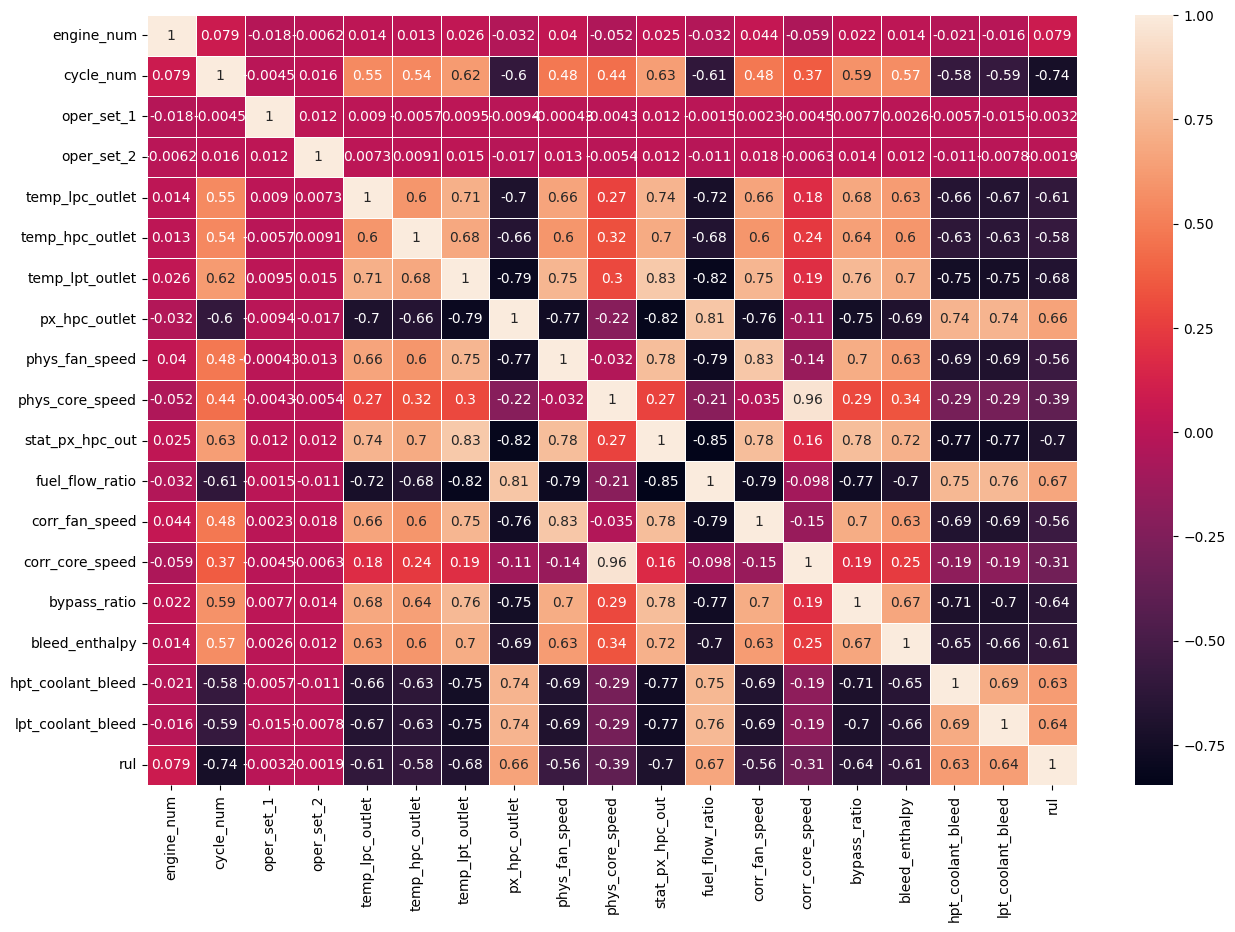

In [123]:
corr_matrix = train_001.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5)
plt.gcf().set_size_inches(15, 10)
plt.show()

In [124]:

corr_unstacked = corr_matrix.unstack()
sorted_corr = corr_unstacked.sort_values(kind="quicksort", ascending=False)
sorted_corr = sorted_corr[sorted_corr != 1]
top_10_corr = sorted_corr.drop_duplicates().head(10)
print("Top 10 correlations:\n", top_10_corr)

Top 10 correlations:
 corr_core_speed    phys_core_speed      0.963157
temp_lpt_outlet    stat_px_hpc_out      0.830136
phys_fan_speed     corr_fan_speed       0.826084
px_hpc_outlet      fuel_flow_ratio      0.812713
phys_fan_speed     stat_px_hpc_out      0.782213
bypass_ratio       stat_px_hpc_out      0.780913
corr_fan_speed     stat_px_hpc_out      0.780761
temp_lpt_outlet    bypass_ratio         0.758459
lpt_coolant_bleed  fuel_flow_ratio      0.756263
fuel_flow_ratio    hpt_coolant_bleed    0.751943
dtype: float64


In [125]:
train_001.drop(columns="corr_core_speed", inplace=True)
test_001.drop(columns="corr_core_speed", inplace=True)
print("Training data shape after dropping 'corr_core_speed': ", train_001.shape)
print("Test data shape after dropping 'corr_core_speed': ", test_001.shape)


Training data shape after dropping 'corr_core_speed':  (20631, 18)
Test data shape after dropping 'corr_core_speed':  (13096, 17)


In [126]:
train_001_with_cycle=train_001.copy()
test_001_with_cycle=test_001.copy()
train_001.drop(columns="cycle_num", inplace=True)
test_001.drop(columns="cycle_num", inplace=True)
print("Training data shape after dropping 'cycle_num': ", train_001.shape)
print("Test data shape after dropping 'cycle_num': ", test_001.shape)

Training data shape after dropping 'cycle_num':  (20631, 17)
Test data shape after dropping 'cycle_num':  (13096, 16)


In [129]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_001[FEATURES_TO_SCALE])
scaled_test_features = scaler.transform(test_001[FEATURES_TO_SCALE])
scaled_train_df = pd.DataFrame(scaled_train_features, columns=FEATURES_TO_SCALE)
scaled_test_df = pd.DataFrame(scaled_test_features, columns=FEATURES_TO_SCALE)
scaled_train_df['engine_num'] = train_001['engine_num'].values
scaled_test_df['engine_num'] = test_001['engine_num'].values
train_final_columns = ['engine_num'] + FEATURES_TO_SCALE
test_final_columns = ['engine_num'] + FEATURES_TO_SCALE
scaled_train_df = scaled_train_df[train_final_columns]
scaled_test_df = scaled_test_df[test_final_columns]
with open('../items/scaler_001.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [130]:
min_training_window = train_001_with_cycle.groupby("engine_num")["cycle_num"].max().min()
min_test_window = test_001_with_cycle.groupby("engine_num")["cycle_num"].max().min()
print("Minimum window size possible for training:", min_training_window)
print("Minimum window size possible for test:", min_test_window)



Minimum window size possible for training: 128
Minimum window size possible for test: 31


In [131]:
scaled_train_df.to_pickle('../data_processed/scaled_train_df_001.pkl')
scaled_test_df.to_pickle('../data_processed/scaled_test_df_001.pkl')
train_001.to_pickle('../data_processed/train_001.pkl')
rul_001.to_pickle('../data_processed/rul_001.pkl')